In [2]:
import torch

from src.model.models import Autoencoder, VAE, DBModel
from src.data.helpers import get_moons_dataset, rotate, get_accuracy

from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
autoencoder_mse = Autoencoder(16, 0.2)
autoencoder_mse.load_state_dict(torch.load('../models/autoencoders/autoencoder_mseloss/model_final.pth'))
autoencoder_mse.eval()

autoencoder_dbloss = Autoencoder(2, 0.2)
autoencoder_dbloss.load_state_dict(torch.load('../models/autoencoders/autoencoder_dbloss/model_final.pth'))
autoencoder_dbloss.eval()

vae_mseloss = VAE(16, 0.2)
vae_mseloss.load_state_dict(torch.load('../models/autoencoders/vae_mseloss/model_kdl1.pth'))
vae_mseloss.eval()

vae_dbloss = VAE(2, 0.2)
vae_dbloss.load_state_dict(torch.load('../models/autoencoders/vae_dbloss/model_kdl20.pth'))
vae_dbloss.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=33, out_features=1024, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=128, out_features=2, bias=True)
  )
  (mu): Linear(in_features=2, out_features=2, bias=True)
  (logvar): 

In [4]:
raw = pd.read_csv("../data/zoo_small.csv")
weights_0 = raw.loc[raw["angle"] == 0].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_45 = raw.loc[raw["angle"] == 45].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_90 = raw.loc[raw["angle"] == 90].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_135 = raw.loc[raw["angle"] == 135].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_180 = raw.loc[raw["angle"] == 180].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_225 = raw.loc[raw["angle"] == 225].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_270 = raw.loc[raw["angle"] == 270].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_315 = raw.loc[raw["angle"] == 315].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()

weights = [weights_0, weights_45, weights_90, weights_135, weights_180, weights_225, weights_270, weights_315]
angles = [0, 45, 90, 135, 180, 225, 270, 315]

X, y = get_moons_dataset()

autoencoder_mseloss_accuracies = []
autoencoder_dbloss_accuracies = []
vae_mseloss_accuracies = []
vae_dbloss_accuracies = []

for i in tqdm(range(0, 7)):
    for j in range(10000):
        weight_1 = weights[i][j]
        weight_2 = weights[i+1][j]
        angle_1 = angles[i]
        angle_2 = angles[i+1]

        alpha = np.random.uniform(0.4, 0.6)

        latent_1 = autoencoder_mse.encoder(torch.tensor(weight_1).float().unsqueeze(0))
        latent_2 = autoencoder_mse.encoder(torch.tensor(weight_2).float().unsqueeze(0))
        latent = (1-alpha)*latent_1 + alpha*latent_2
        angle = (1-alpha)*angle_1 + alpha*angle_2

        w = autoencoder_mse.decoder(latent).squeeze()
        X_rotated = rotate(X, angle)
        X_rotated = torch.tensor(X_rotated).float()
        accuracy = get_accuracy(w, X_rotated, y)
        autoencoder_mseloss_accuracies.append(accuracy)


        latent_1 = autoencoder_dbloss.encoder(torch.tensor(weight_1).float().unsqueeze(0))
        latent_2 = autoencoder_dbloss.encoder(torch.tensor(weight_2).float().unsqueeze(0))
        latent = (1-alpha)*latent_1 + alpha*latent_2
        angle = (1-alpha)*angle_1 + alpha*angle_2

        w = autoencoder_dbloss.decoder(latent).squeeze()
        X_rotated = rotate(X, angle)
        X_rotated = torch.tensor(X_rotated).float()
        accuracy = get_accuracy(w, X_rotated, y)
        autoencoder_dbloss_accuracies.append(accuracy)

        latent_1 = vae_mseloss.encoder(torch.tensor(weight_1).float().unsqueeze(0))
        mean_1 = vae_mseloss.mu(latent_1)
        logvar_1 = vae_mseloss.logvar(latent_1)
        latent_1 = vae_mseloss.reparameterize(mean_1, logvar_1)

        latent_2 = vae_mseloss.encoder(torch.tensor(weight_2).float().unsqueeze(0))
        mean_2 = vae_mseloss.mu(latent_2)
        logvar_2 = vae_mseloss.logvar(latent_2)
        latent_2 = vae_mseloss.reparameterize(mean_2, logvar_2)

        latent = (1-alpha)*latent_1 + alpha*latent_2
        angle = (1-alpha)*angle_1 + alpha*angle_2

        w = vae_mseloss.decoder(latent).squeeze()
        X_rotated = rotate(X, angle)
        X_rotated = torch.tensor(X_rotated).float()
        accuracy = get_accuracy(w, X_rotated, y)
        vae_mseloss_accuracies.append(accuracy)


        latent_1 = vae_dbloss.encoder(torch.tensor(weight_1).float().unsqueeze(0))
        mean_1 = vae_dbloss.mu(latent_1)
        logvar_1 = vae_dbloss.logvar(latent_1)
        latent_1 = vae_dbloss.reparameterize(mean_1, logvar_1)

        latent_2 = vae_dbloss.encoder(torch.tensor(weight_2).float().unsqueeze(0))
        mean_2 = vae_dbloss.mu(latent_2)
        logvar_2 = vae_dbloss.logvar(latent_2)
        latent_2 = vae_dbloss.reparameterize(mean_2, logvar_2)

        latent = (1-alpha)*latent_1 + alpha*latent_2
        angle = (1-alpha)*angle_1 + alpha*angle_2

        w = vae_dbloss.decoder(latent).squeeze()
        X_rotated = rotate(X, angle)
        X_rotated = torch.tensor(X_rotated).float()
        accuracy = get_accuracy(w, X_rotated, y)
        vae_dbloss_accuracies.append(accuracy)

print(f"Mean Autoencoder (MSELoss) accuracy: {np.mean(autoencoder_mseloss_accuracies)}")
print(f"Mean Autoencoder (DBLoss) accuracy: {np.mean(autoencoder_dbloss_accuracies)}")
print(f"Mean VAE (MSELoss) accuracy: {np.mean(vae_mseloss_accuracies)}")
print(f"Mean VAE (DBLoss) accuracy: {np.mean(vae_dbloss_accuracies)}")

  0%|          | 0/7 [00:00<?, ?it/s]

Mean Autoencoder (MSELoss) accuracy: 83.11861857142858
Mean Autoencoder (DBLoss) accuracy: 97.38568285714287
Mean VAE (MSELoss) accuracy: 76.39532
Mean VAE (DBLoss) accuracy: 98.13271142857143


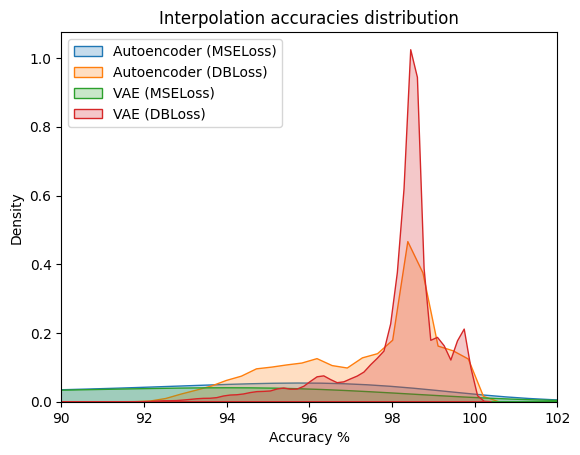

In [15]:
sns.kdeplot(autoencoder_mseloss_accuracies, fill=True, label="Autoencoder (MSELoss)")
sns.kdeplot(autoencoder_dbloss_accuracies, fill=True, label="Autoencoder (DBLoss)")
sns.kdeplot(vae_mseloss_accuracies, fill=True, label="VAE (MSELoss)")
sns.kdeplot(vae_dbloss_accuracies, fill=True, label="VAE (DBLoss)")

plt.legend(loc="upper left")
plt.title("Interpolation accuracies distribution")
plt.xlabel("Accuracy %")
plt.xlim(90, 102)
plt.show()

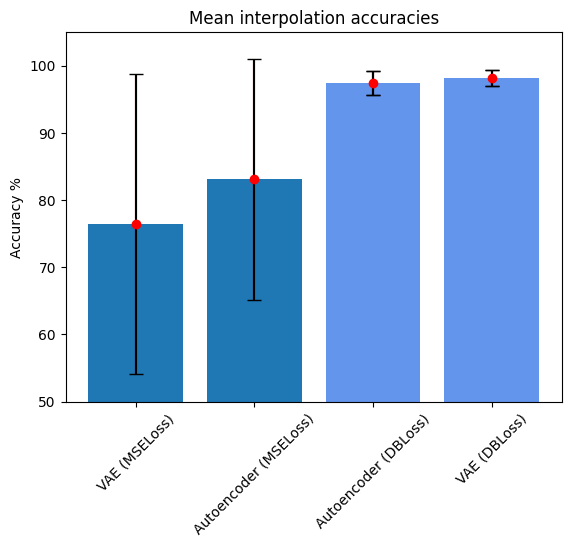

In [12]:
autoencoder_mseloss_mean = np.mean(autoencoder_mseloss_accuracies)
autoencoder_dbloss_mean = np.mean(autoencoder_dbloss_accuracies)
vae_mseloss_mean = np.mean(vae_mseloss_accuracies)
vae_dbloss_mean = np.mean(vae_dbloss_accuracies)

autoencoder_mseloss_std = np.std(autoencoder_mseloss_accuracies)
autoencoder_dbloss_std = np.std(autoencoder_dbloss_accuracies)
vae_mseloss_std = np.std(vae_mseloss_accuracies)
vae_dbloss_std = np.std(vae_dbloss_accuracies)


x = np.array(["VAE (MSELoss)","Autoencoder (MSELoss)", "Autoencoder (DBLoss)", "VAE (DBLoss)"])
y = np.array([vae_mseloss_mean, autoencoder_mseloss_mean, autoencoder_dbloss_mean, vae_dbloss_mean])
e = np.array([vae_mseloss_std, autoencoder_mseloss_std, autoencoder_dbloss_std, vae_dbloss_std])

plt.errorbar(x, y, e, fmt="o", color="r")

# make these tick labels look good

# make bars thicker
plt.bar(x, y, yerr=e, capsize=5)


# color every second bar green
plt.bar(x[2], y[2], yerr=e[2], capsize=5, color="cornflowerblue")
plt.bar(x[3], y[3], yerr=e[3], capsize=5, color="cornflowerblue")

plt.ylim(50, 105)
plt.xticks(x, rotation=45)
plt.title("Mean interpolation accuracies")
plt.ylabel("Accuracy %")
plt.show()

## KD Weight effect

In [11]:
autoencoder = VAE(2)
autoencoder.eval()
kdl_weights = [1, 5, 10, 20, 30, 40 , 500]
accuracies = []


raw = pd.read_csv("../data/zoo_small.csv")
weights_0 = raw.loc[raw["angle"] == 0].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_45 = raw.loc[raw["angle"] == 45].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_90 = raw.loc[raw["angle"] == 90].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_135 = raw.loc[raw["angle"] == 135].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_180 = raw.loc[raw["angle"] == 180].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_225 = raw.loc[raw["angle"] == 225].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_270 = raw.loc[raw["angle"] == 270].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_315 = raw.loc[raw["angle"] == 315].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()

weights = [weights_0, weights_45, weights_90, weights_135, weights_180, weights_225, weights_270, weights_315]
angles = [0, 45, 90, 135, 180, 225, 270, 315]

X, y = get_moons_dataset()

for kdl_weight in kdl_weights:
    t = []
    autoencoder.load_state_dict(torch.load("../models/autoencoders/vae/model_kdl{}.pth".format(kdl_weight)))

    for i in tqdm(range(0, 7)):
        for j in range(10000):
            weight_1 = weights[i][j]
            weight_2 = weights[i+1][j]
            angle_1 = angles[i]
            angle_2 = angles[i+1]

            alpha = np.random.uniform(0.4, 0.6)

            latent_1 = autoencoder.encoder(torch.tensor(weight_1).float().unsqueeze(0))
            latent_2 = autoencoder.encoder(torch.tensor(weight_2).float().unsqueeze(0))
            latent = (1-alpha)*latent_1 + alpha*latent_2
            angle = (1-alpha)*angle_1 + alpha*angle_2

            mean = autoencoder.mu(latent)
            logvar = autoencoder.logvar(latent)
            latent = autoencoder.reparameterize(mean, logvar)

            w = autoencoder.decoder(latent).squeeze()
            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated).float()
            accuracy = get_accuracy(w, X_rotated, y)
            # if(accuracy < 50):
            #     print(i)
            #     print(i+1)
            #     print(j)
            t.append(accuracy)

    mean_accuracy = np.mean(t)
    accuracies.append(mean_accuracy)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [20]:
print(kdl_weights)
print(accuracies)

[1, 5, 10, 20, 30, 40, 500]
[97.71746857142857, 97.48995428571428, 97.60866142857144, 98.00964142857143, 97.79863714285713, 96.87574285714284, 50.0]
